In [1]:
import os

root_directory = os.path.join(os.getcwd(), "Water Bodies Dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")

Dataset path: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset
Dataset directory found!


In [5]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [9]:
import os

base_path = "/Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset"
image_path = os.path.join(base_path, "Images/")
mask_path = os.path.join(base_path, "Masks/")

if os.path.exists(image_path):
    print(f"Image path found: {image_path}")
else:
    print("Image path not found.")

if os.path.exists(mask_path):
    print(f"Mask path found: {mask_path}")
else:
    print("Mask path not found.")


Image path found: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset/Images/
Mask path found: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset/Masks/


In [10]:
SIZE = 128

In [11]:
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = np.asarray(Image.open(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = np.asarray(Image.open(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:09<00:00, 287.35it/s]


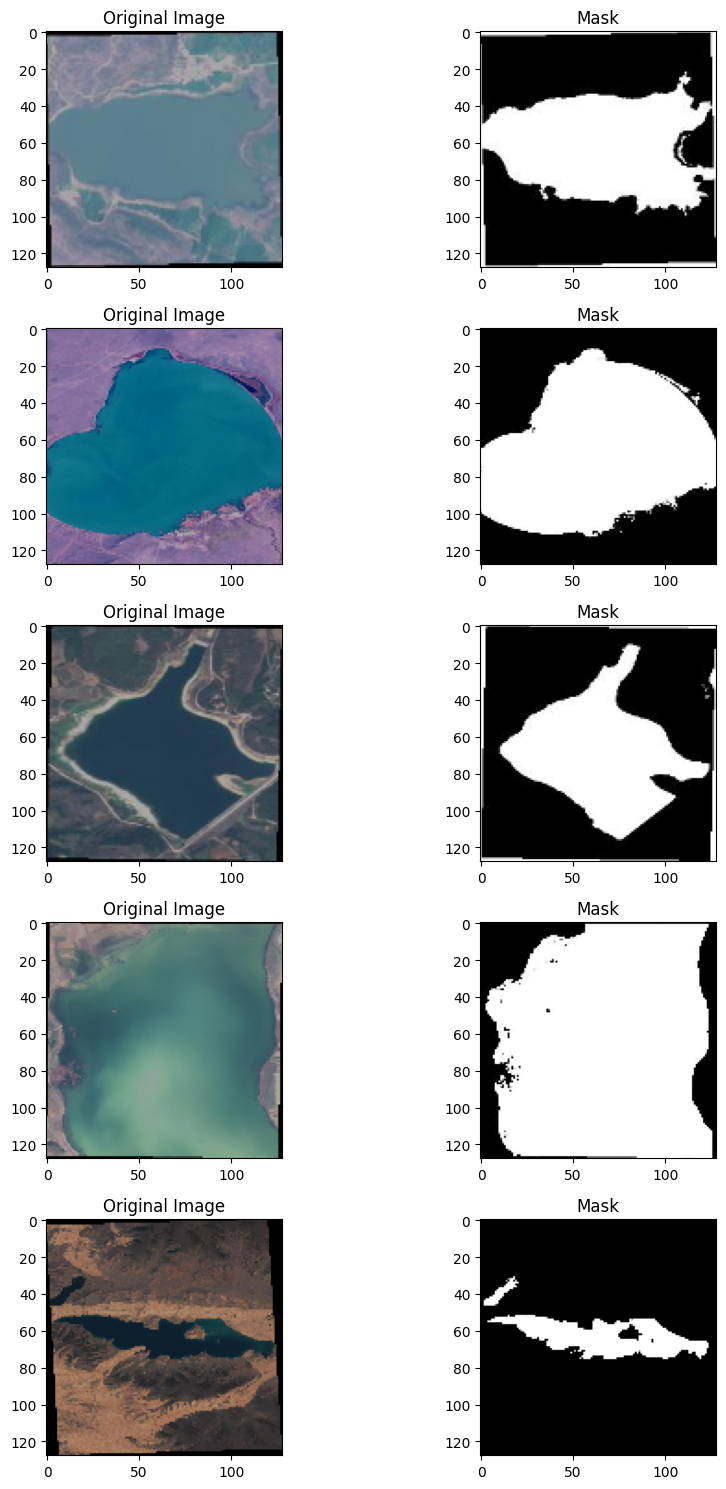

In [12]:
# Plot some images and its masks
plt.figure(figsize=(10,15))
for i in range(1,11):
  plt.subplot(5,2,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id], cmap=None)
    plt.title('Original Image')
  elif i%2==0:
    plt.imshow(masks[id].reshape(128,128), cmap='gray')
    plt.title('Mask')

plt.tight_layout()
plt.show()
     


In [13]:
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [14]:
def unet_model(input_layer, start_neurons):
    # Contraction path
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(convm)
    
    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, kernel_size=(3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    
    # Last conv and output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer = input_layer, start_neurons = 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 128) │          0 │ max_pooling2d_3[

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Post Process
def mask_threshold(image, threshold=0.25):
  return image>threshold

# Callback to show progress of learning on the images after each epoch

     

In [25]:
epochs = 5
batch_size = 32

history1 = model.fit(images_train, mask_train,
                    validation_data=(images_test, mask_test), 
                    epochs=epochs,
                    batch_size=batch_size)


Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 616ms/step - accuracy: 0.7282 - loss: 0.2570 - val_accuracy: 0.7281 - val_loss: 0.2739
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 618ms/step - accuracy: 0.7293 - loss: 0.2566 - val_accuracy: 0.7381 - val_loss: 0.2690
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 616ms/step - accuracy: 0.7325 - loss: 0.2592 - val_accuracy: 0.7322 - val_loss: 0.2771
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7337 - loss: 0.2530 - val_accuracy: 0.7333 - val_loss: 0.2661
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 0.7350 - loss: 0.2575 - val_accuracy: 0.7333 - val_loss: 0.2668


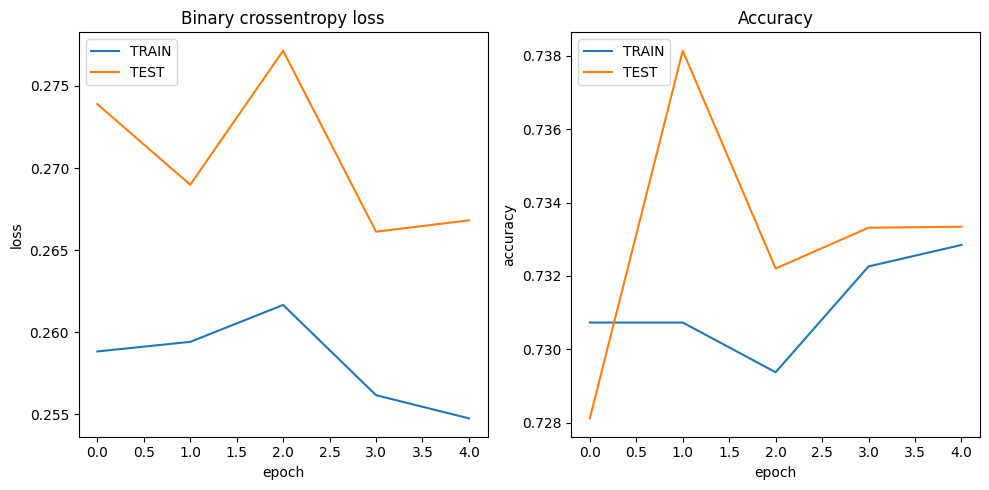

In [26]:
plt.figure(figsize=(10,5))

# Plot loss for each epoch
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], label="Train loss")
plt.plot(history1.history['val_loss'], label="Test loss")
plt.title('Binary crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

# Plot accuracy for each epoch
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'], label="Train accuracy")
plt.plot(history1.history['val_accuracy'], label="Test accuracy")
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

plt.tight_layout()
plt.show() 

In [18]:
model.save("unet_plus_plus_se2_model.h5") 